#Phone Prices Random Foreest

##Set up

In [ ]:
use_grid_search = False

use_mean = True
use_median = False

In [ ]:
# use_mean = False
# use_median = False
# choice = ''
# while choice not in ['1', '2', '3']:
#   print('1. Use mean')
#   print('2. Use median')
#   print('3. Use mode')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_mean = True
# elif choice == '2':
#   use_median = True

# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False

##Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

##Importing Dataset

In [ ]:
data = pd.read_csv('cleaned_all_phones.csv')

data.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


In [ ]:
data.columns

Index(['phone_name', 'brand', 'os', 'inches', 'resolution', 'battery',
       'battery_type', 'ram(GB)', 'announcement_date', 'weight(g)',
       'storage(GB)', 'video_720p', 'video_1080p', 'video_4K', 'video_8K',
       'video_30fps', 'video_60fps', 'video_120fps', 'video_240fps',
       'video_480fps', 'video_960fps', 'price(USD)'],
      dtype='object')

In [ ]:
data.shape

(1512, 22)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   resolution         1512 non-null   object 
 5   battery            1512 non-null   int64  
 6   battery_type       1512 non-null   object 
 7   ram(GB)            1512 non-null   int64  
 8   announcement_date  1512 non-null   object 
 9   weight(g)          1512 non-null   float64
 10  storage(GB)        1512 non-null   int64  
 11  video_720p         1512 non-null   bool   
 12  video_1080p        1512 non-null   bool   
 13  video_4K           1512 non-null   bool   
 14  video_8K           1512 non-null   bool   
 15  video_30fps        1512 non-null   bool   
 16  video_60fps        1512 

In [ ]:
data.describe()

,inches,battery,ram(GB),weight(g),storage(GB),price(USD)
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,6.422460,4389.798942,6.683862,187.636243,109.164683,337.847036
std,0.477043,784.607022,2.701433,26.200115,74.436484,266.740821
min,3.800000,1821.000000,1.000000,130.000000,1.000000,40.000000
25%,6.300000,4000.000000,4.000000,175.000000,64.000000,179.997500
50%,6.500000,4500.000000,8.000000,187.000000,128.000000,260.000000
75%,6.670000,5000.000000,8.000000,197.250000,128.000000,400.000000
max,10.400000,7250.000000,24.000000,500.000000,512.000000,2300.000000


In [ ]:
for col in data.columns:
  print(data[col].value_counts())
  print()

phone_name
V30              3
8 Pro            2
10 Pro           2
11               2
6                2
                ..
Find X2          1
Find X2 Pro      1
6 Pro            1
P40 lite E       1
Redmi Note 9S    1
Name: count, Length: 1496, dtype: int64

brand
Xiaomi     264
Oppo       213
Samsung    206
Vivo       168
Realme     157
Huawei     137
Honor      124
LG          75
OnePlus     47
Lenovo      43
Sony        37
Apple       22
Google      19
Name: count, dtype: int64

os
Android 11                322
Android 10                317
Android 12                233
Android 9.0               210
Android 13                154
Android 8.1                83
Android 8.0                55
Android 7.0                33
Android 7.1.1              17
Android 7.1                14
Android 7.1.2              13
Android 6.0                 6
EMUI 12                     6
Android 8.1 Oreo            5
iOS 16                      4
iOS 13                      4
iOS 14.1                    

Looking for null values

In [ ]:
data.isnull().sum()

,0
phone_name,0
brand,0
os,0
inches,0
resolution,0
battery,0
battery_type,0
ram(GB),0
announcement_date,0
weight(g),0


Looking for duplicates

In [ ]:
data.duplicated().sum()

np.int64(0)

##Cleaning


In [ ]:
cleaned = data.copy()

cleaned['price'] = cleaned['price(USD)']
cleaned.drop('price(USD)', axis=1, inplace=True)

###Filling in missing string values with "Not Defined" and numerical values with either mean, mode or median

In [ ]:
cleaned.isnull().sum()

,0
phone_name,0
brand,0
os,0
inches,0
resolution,0
battery,0
battery_type,0
ram(GB),0
announcement_date,0
weight(g),0


In [ ]:
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    cleaned[col] = cleaned[col].fillna(value = "Not Defined")
  elif use_mean:
    cleaned[col] = cleaned[col].fillna(cleaned[col].mean())
  elif use_median:
    cleaned[col] = cleaned[col].fillna(cleaned[col].median())
  else:
    cleaned[col] = cleaned[col].fillna(cleaned[col].mode()[0])

Rechecking nulls

In [ ]:
cleaned.isnull().sum()

,0
phone_name,0
brand,0
os,0
inches,0
resolution,0
battery,0
battery_type,0
ram(GB),0
announcement_date,0
weight(g),0


Rechecking duplicates

In [ ]:
cleaned.duplicated().sum()

np.int64(0)

###Separating resolution and also multiplying

In [ ]:
cleaned[['resolution_height', 'resolution_width']] = cleaned['resolution'].str.split('x', expand=True)
cleaned.drop('resolution', axis=1, inplace=True)

In [ ]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   battery            1512 non-null   int64  
 5   battery_type       1512 non-null   object 
 6   ram(GB)            1512 non-null   int64  
 7   announcement_date  1512 non-null   object 
 8   weight(g)          1512 non-null   float64
 9   storage(GB)        1512 non-null   int64  
 10  video_720p         1512 non-null   bool   
 11  video_1080p        1512 non-null   bool   
 12  video_4K           1512 non-null   bool   
 13  video_8K           1512 non-null   bool   
 14  video_30fps        1512 non-null   bool   
 15  video_60fps        1512 non-null   bool   
 16  video_120fps       1512 

In [ ]:
cleaned['resolution_height'] = cleaned['resolution_height'].astype('int')
cleaned['resolution_width'] = cleaned['resolution_width'].astype('int')

In [ ]:
cleaned['resolution'] = cleaned['resolution_height'] * cleaned['resolution_width']

###Finding unique os

In [ ]:
print(cleaned['os'].unique())

['Android 5.1' 'Android 7.0' 'Android 6.0' 'Android 7.1' 'Android 6'
 'Android 7.0.1' 'Android 6.0.1' 'Android 7.1.1' 'Tizen 3.0' 'Android 8.0'
 'Android 7.1.2' 'iOS 11' 'iOS 11.1.1' 'Android 8.1' 'Android 8.0 Oreo'
 'Android 9.0' 'Android 8.1 Oreo' 'iOS 12' 'Android 9.0 Pie' 'Android 10'
 'iOS 13' 'Android 11' 'iOS 14.1' 'Android 10/ Android 11' 'iOS 15'
 'Android 12' 'iOS 15.4' 'EMUI 12' 'Android' 'Android 12L' 'iOS 16'
 'Android 13' 'Android 12 or 13' 'EMUI 13']


In [ ]:
os_unique = []
for val in cleaned['os']:
  if 'Android' in val:
    os_unique.append('Android')
  elif 'iOS' in val:
    os_unique.append('iOS')
  elif 'Tizen' in val:
    os_unique.append('Tizen')
  elif 'EMUI' in val:
    os_unique.append('EMUI')
  else:
    print('ERROR: ', val, ' not accounted for')

In [ ]:
cleaned['os_unique'] = os_unique

###Pixels per inch

In [ ]:
cleaned['ppi']=(((cleaned['resolution_height']**2) + (cleaned['resolution_width']**2))**0.5/cleaned['inches']).astype('float')

###Extracting Year

In [ ]:
# cleaned['announcement_date'] = pd.to_datetime(cleaned['announcement_date'])
# cleaned['year'] = cleaned['announcement_date'].dt.year

###Anomally handling

Helper function to polt the box plots

In [ ]:
Q3 = cleaned['price'].quantile(0.75)
Q1 = cleaned['price'].quantile(0.25)
IQR = Q3 - Q1
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)

Q1: 179.9975
Q3: 400.0
IQR: 220.0025


In [ ]:
print(Q3 + 1.5 * IQR)
cleaned[cleaned['price'] > (Q3 + 1.5 * IQR)]

730.00375


,phone_name,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_height,resolution_width,resolution,os_unique,ppi
133,Y3 (2018),Huawei,Android 8.0 Oreo,5.00,2280,Li-Ion,1,2018-05-01,175.0,8,...,False,False,False,False,1300.0,480,854,409920,Android,195.930192
215,K1,Oppo,Android 8.1,6.40,3600,Li-Ion,6,2018-10-01,156.0,64,...,False,False,False,False,1350.0,1080,2340,2527200,Android,402.688717
232,Enjoy 9,Huawei,Android 8.1,6.26,4000,Li-Po,4,2018-12-01,168.0,32,...,False,False,False,False,800.0,720,1520,1094400,Android,268.674710
234,nova 4,Huawei,Android 9.0,6.40,3750,Li-Po,8,2018-12-01,172.0,128,...,False,False,False,False,1200.0,1080,2310,2494800,Android,398.437500
333,7 Pro 5G,OnePlus,Android 9.0,6.67,4000,Li-Po,6,2019-05-14,206.0,128,...,True,True,True,False,800.0,1440,3120,4492800,Android,515.183966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,Magic V2,Honor,Android 13,7.92,5000,Li-Po,16,2023-07-12,231.0,256,...,False,False,False,False,1130.0,2156,2344,5053664,Android,402.115681
1494,K11,Oppo,Android 13,6.70,5000,Li-Po,8,2023-07-25,184.0,256,...,True,False,False,False,759.0,1080,2400,2592000,Android,392.806786
1496,Galaxy Z Flip5,Samsung,Android 13,6.70,3700,Li-Po,8,2023-07-26,187.0,256,...,True,True,False,True,899.0,1080,2640,2851200,Android,425.726483
1497,Galaxy Z Fold5,Samsung,Android 13,7.60,4400,Li-Po,12,2023-07-26,253.0,256,...,True,True,False,True,1498.2,1812,2176,3942912,Android,372.587345


In [ ]:
cleaned[cleaned['price'] < (Q1 - 1.5 * IQR)]

,phone_name,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_height,resolution_width,resolution,os_unique,ppi


In [ ]:
def box_plot(df, x, y):
  plt.figure(figsize=(14,6))
  sns.boxplot(x=df[x], y=df[y])
  plt.xticks(rotation='vertical')
  plt.show()

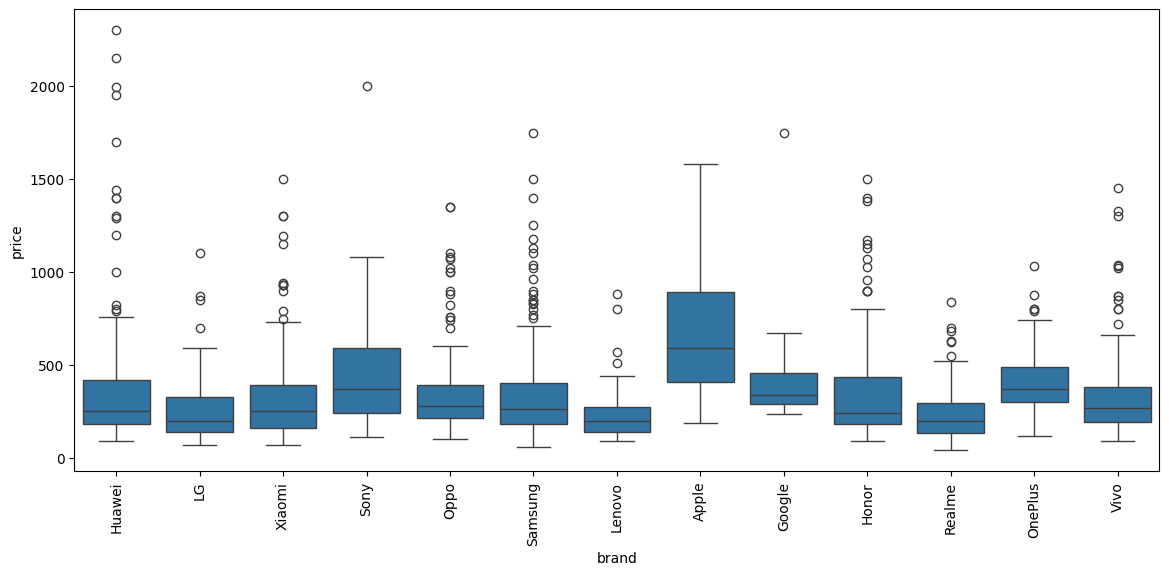

In [ ]:
box_plot(cleaned, 'brand', 'price')

In [ ]:
# cleaned.drop(cleaned[cleaned['price'] > 1400].index, inplace=True)

In [ ]:
cleaned.drop(cleaned[cleaned['price'] > (Q3 + 1.5 * IQR)].index, inplace=True)
cleaned.drop(cleaned[cleaned['price'] < (Q1 - 1.5 * IQR)].index, inplace=True)

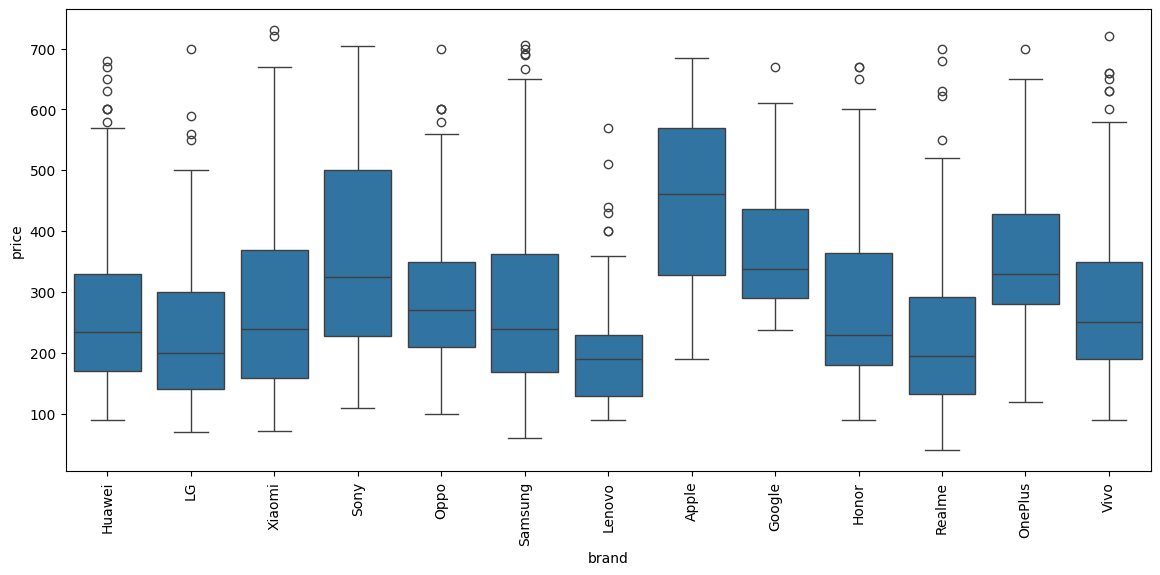

In [ ]:
box_plot(cleaned, 'brand', 'price')

##Preparing data for modelling

###Dropping columns

In [ ]:
cleaned.drop('phone_name', inplace=True, axis=1)

###Scaling Numerical Data

In [ ]:
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    continue
  if col == 'price':
    price_scaler = StandardScaler()
    cleaned[col] = price_scaler.fit_transform(cleaned[col].values.reshape(-1,1))
    continue
  scaler = StandardScaler()
  cleaned[col] = scaler.fit_transform(cleaned[col].values.reshape(-1,1))

In [ ]:
cleaned.head()

,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),video_720p,...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_height,resolution_width,resolution,os_unique,ppi
0,Huawei,Android 5.1,-2.985865,-2.736211,Li-Po,-1.742762,2016-09-01,-1.838699,-1.285731,0.965616,...,-0.591364,-0.361595,-0.152888,-0.40091,-1.111165,-1.254407,-1.971246,-1.514783,Android,-1.134867
1,LG,Android 7.0,-2.345753,-2.109478,Li-Ion,-1.742762,2016-12-01,-1.838699,-1.285731,-1.035609,...,-0.591364,-0.361595,-0.152888,-0.40091,-1.251401,-1.254407,-1.971246,-1.514783,Android,-1.363231
2,Huawei,Android 7.0,-2.559124,-1.733438,Li-Ion,-0.974960,2017-01-01,-1.560163,-1.285731,-1.035609,...,-0.591364,-0.361595,-0.152888,-0.40091,0.992380,0.256075,-0.575621,-0.260894,Android,0.649588
3,Xiaomi,Android 6.0,-1.919012,-0.354625,Li-Po,-0.974960,2017-01-01,-0.843929,-1.050897,0.965616,...,1.691007,-0.361595,-0.152888,-0.40091,-0.900810,0.256075,-0.575621,-0.260894,Android,0.332194
4,Huawei,Android 7.0,-2.772495,-1.482745,Li-Ion,-0.974960,2017-02-01,-1.639745,-1.050897,0.965616,...,-0.591364,-0.361595,-0.152888,-0.40091,0.992380,0.256075,-0.575621,-0.260894,Android,0.763683


###Encoding Strings

In [ ]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

cleaned.head()

brand
os
battery_type
announcement_date
os_unique


,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),video_720p,...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_height,resolution_width,resolution,os_unique,ppi
0,Huawei,Android 5.1,-2.985865,-2.736211,Li-Po,-1.742762,2016-09-01,-1.838699,-1.285731,0.965616,...,-0.591364,-0.361595,-0.152888,-0.40091,-1.111165,-1.254407,-1.971246,-1.514783,Android,-1.134867
1,LG,Android 7.0,-2.345753,-2.109478,Li-Ion,-1.742762,2016-12-01,-1.838699,-1.285731,-1.035609,...,-0.591364,-0.361595,-0.152888,-0.40091,-1.251401,-1.254407,-1.971246,-1.514783,Android,-1.363231
2,Huawei,Android 7.0,-2.559124,-1.733438,Li-Ion,-0.974960,2017-01-01,-1.560163,-1.285731,-1.035609,...,-0.591364,-0.361595,-0.152888,-0.40091,0.992380,0.256075,-0.575621,-0.260894,Android,0.649588
3,Xiaomi,Android 6.0,-1.919012,-0.354625,Li-Po,-0.974960,2017-01-01,-0.843929,-1.050897,0.965616,...,1.691007,-0.361595,-0.152888,-0.40091,-0.900810,0.256075,-0.575621,-0.260894,Android,0.332194
4,Huawei,Android 7.0,-2.772495,-1.482745,Li-Ion,-0.974960,2017-02-01,-1.639745,-1.050897,0.965616,...,-0.591364,-0.361595,-0.152888,-0.40091,0.992380,0.256075,-0.575621,-0.260894,Android,0.763683


In [ ]:
for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", random_state=42, smooth = 5)
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    cleaned[col] = encoder.transform(X)

In [ ]:
cleaned.columns

Index(['brand', 'os', 'inches', 'battery', 'battery_type', 'ram(GB)',
       'announcement_date', 'weight(g)', 'storage(GB)', 'video_720p',
       'video_1080p', 'video_4K', 'video_8K', 'video_30fps', 'video_60fps',
       'video_120fps', 'video_240fps', 'video_480fps', 'video_960fps', 'price',
       'resolution_height', 'resolution_width', 'resolution', 'os_unique',
       'ppi'],
      dtype='object')

In [ ]:
cleaned.isnull().sum()

,0
brand,0
os,0
inches,0
battery,0
battery_type,0
ram(GB),0
announcement_date,0
weight(g),0
storage(GB),0
video_720p,0


##Building Model

###Loading X and y

In [ ]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [ ]:
print(X.shape)
print(y.shape)

(1401, 24)
(1401,)


###Feature Selection

In [ ]:
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(X, y)

X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [ ]:
importances = sfm.estimator_.feature_importances_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
      'Importance': importances
}).sort_values(by='Importance', ascending = False),

print(feature_scores)

# Get the indices of the selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

for col in X.columns:
  if col not in selected_feature_names:
    print("Unselected Features:", col)

(              Feature  Importance
6   announcement_date    0.536078
7           weight(g)    0.069983
23                ppi    0.062311
3             battery    0.051419
0               brand    0.050556
2              inches    0.041168
21         resolution    0.027444
1                  os    0.025376
5             ram(GB)    0.023221
20   resolution_width    0.022308
8         storage(GB)    0.019641
14        video_60fps    0.011989
11           video_4K    0.011728
9          video_720p    0.008412
4        battery_type    0.007743
13        video_30fps    0.007304
15       video_120fps    0.005824
19  resolution_height    0.005215
17       video_480fps    0.003370
18       video_960fps    0.003065
16       video_240fps    0.003061
12           video_8K    0.002407
22          os_unique    0.000346
10        video_1080p    0.000032,)
Unselected Features: os
Unselected Features: inches
Unselected Features: battery_type
Unselected Features: ram(GB)
Unselected Features: storage(GB)

In [ ]:
X = X_new

###Splitting up training and testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1120, 5)
(281, 5)
(1120,)
(281,)


###Finding best parameters

In [ ]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [ ]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3, error_score='raise')


In [ ]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [ ]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [ ]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else:
  # model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)
  model = RandomForestRegressor(max_depth = 100, max_features =  'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap= True, max_leaf_nodes=150, n_estimators = 250, random_state = 42)
  # model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)


model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=150,
                      min_samples_leaf=4, n_estimators=250, random_state=42)

##Testing Model

In [ ]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.718
Test Accuracy:  0.530


In [ ]:
# Making predictions on the test set
y_pred = model.predict(X_test)

y_pred = price_scaler.inverse_transform(y_pred.reshape(-1,1))
y_test = price_scaler.inverse_transform(y_test.values.reshape(-1,1))

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 72.93
Mean Absolute Percentage Error: 0.31


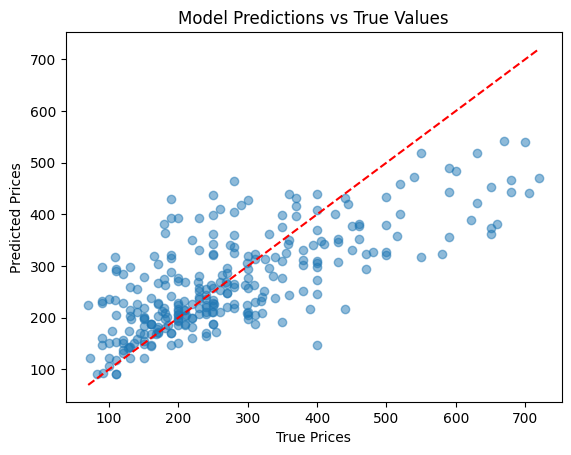

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()